__Tips: Please install Bio before running by:__
pip install biopython

In [178]:
# python3 genome_simulation.py --ini='bacteria.ini' --data='Escherichia_coli_DH10B.fasta'
from configparser import ConfigParser
import optparse
import random, os, sys
import pandas as pd
import logging
from datetime import datetime
import numpy as np
import calendar;
import time;
from Bio import SeqIO 
from decimal import *

#### Step 0. Please configure these parameters accordingly before running:
* ALL parameters in configuration will be kept in the format of 'conf_XXXXX' for easily recognization.
* #### For [dendrogram]:
    * linkage_method: 'single', 'weighted', 'average', 'centroid', 'median', 'ward'
    * metric: pdist: 'euclidean', 'minkowski', 'cityblock'(manhattan), 'seuclidean', 'cosine', 'correlation', 'hamming', 'canberra', 'jaccard', 'chebyshev', 'canberra', 'braycurtis', 'yule', 'matching' etc.
REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html;
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

In [179]:
#[lamba]
# conf_lamba_min/max: It is on a per generation basis ... update mutation rate to different values within the range. 
# conf_lamba_min/max:Start by one generation the min rate then the next the max rate then the min rate etc
# conf_lamba_min=0.1 
# conf_lamba_max=0.5

# conf_lamba: can have multiple lambas
conf_lamba=0.2,0.1,0.3
conf_generation=7

#[mutation]
# run_times: How many mutated seqs will be generated.
conf_run_times=4 
conf_numrows=1

#[fasta]
# conf_filepath: The path of fasta file.
conf_filepath = '../Escherichia_coli_DH10B.fasta'
# conf_top_num: How many bases could be kept from fasta file.
conf_top_num = 40 
# conf_generated_file_format: specify the format will be generated with: '.nex','.txt' etc.
conf_generated_file_format = '.txt'

# [pdist]
if_add_hamming = 0 # 1: Add hamming distance as the column for pdist & dendrogram; 0: Remove hamming distance for dendrogram;

# For VARYING LAMBDA:
#1  alternating min-max-min-max-min-max
#2. Random within range
#3. Constant lambda (done)

#[dendrogram]
linkage_method = 'median'         # 'single', 'weighted', 'average', 'centroid', 'median', 'ward'
pdistance_method =  'hamming' #  'euclidean', 'minkowski', 'cityblock'(manhattan), 'seuclidean', 'correlation', 'hamming', 'canberra', 'jaccard', 'chebyshev', 'canberra', 'braycurtis', 'yule', 'matching' etc.


#### Step 1. Function definition:
#### A. parse_file(filename, formatname, length): Return the sequencing from file with specified format and length.
#### B. mutate_prob(target_bases_list, prob): Mutate the base by picking from bases list with probability.
#### C. mutation_simulate(ori_seq): Mutate the original sequencing by probability/flipping and return the mutated sequencing, and how many bases have been mutated.

In [180]:
def parse_file(filename, formatname, length): 
    '''
        filename: file path
        formatname: 'fasta', 'abi', 'genbank or gb' etc...
        length: top number for snipping
    '''
    with open(filename, "rU") as handle:
        for record in SeqIO.parse(handle, formatname) :
            if len(record.seq)>length:
                base_top = record.seq[:length]
        return record, base_top

In [181]:
#Hamming distance of 2 string:
def hamming_dist(str1, str2):
    return sum(str1 != str2 for str1, str2 in zip(str1, str2))

In [182]:
def mutate_prob(target_bases_list, prob1): 
    picked_base = np.random.choice(target_bases_list, 1, prob1) #Pick 1 from target list based on prob1.
    return picked_base

In [183]:
def mutation_simulate(ori_seq):
    count=0
    mutated_seq=[]

    for ori_base in ori_seq:
        flip = np.random.uniform(0, 1)
        #print('flip on ', ori_base, flip)
        
        lambda_list = list(conf_lamba)
        picked_lamba = np.random.choice(lambda_list, 1)
    
        # For C base: transit to A or G by flip probability (if flip < lamda picked randomly from configuration lambda list.)
        if (ori_base == 'C') and (flip <= picked_lamba): #C-> G or A
            mutated_base = mutate_prob(['A','G'], flip)  #Pick 1 from target list based on flip.
            count+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)
                
        # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
        elif (ori_base == 'G') and (flip <= picked_lamba): #G-> C or T
            mutated_base = mutate_prob(['C','T'], flip)  #Pick 1 from target list based on flip.
            count+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)            
        else:
            mutated_seq.append(ori_base)

    return mutated_seq, count

#### Step 2: Get the specified length of the sequences from the specified file.

In [184]:
# 0. FAKE seq for testing:
# ori_seq='AGCTACTGGC'

In [185]:
# Get the trimmed seq string from specified file.
record, base_top = parse_file(conf_filepath, "fasta", int(conf_top_num))
ori_seq = str(base_top)
print(ori_seq)

AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG


/Users/sikedong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 'U' mode is deprecated
  import sys


#### Step 3: Generate the mutated sequences with specified times and write these mutated sequeces to file with specified format.
- In this case, write the mutated sequeces in .nex file.  
- The file will be named with timestamp.  
- e.g.: __Generated file: GBAC_<Generation\><mutation_rate\>Seq__  
GBAC_7_0.2 AGCTTTTCATTCTGACTGAAACGGGCAATATGTCTCTGTG  
GBAC_7_0.2 AGATTTTCATTCTGACTGCAACGGTCAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGCGCAATATTTCTATCTC  
GBAC_7_0.2 AGATTTTCATTCTGACTTCAACGCGAAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG  

In [186]:
# Generate file name with timestamp.
timestamp = calendar.timegm(time.gmtime())
print(timestamp)
mut_seq_nexfilepath = "file_generated\\"+"SimSeqFile_"+ str(timestamp) + conf_generated_file_format

1565903420


#### Step 4: Generate the sequences and differences for output file.

In [187]:
def compare_seq(seq1, seq2):
    diff_seq = ''
    diff_index = ''
    diff=''
    
    if len(seq1) == len(seq2):
        for i in range(0, len(seq1)):
            if seq1[i]!=seq2[i]:
                diff_seq+=seq2[i]
                diff_index+=str(i)+','
        diff = diff_seq +' '+ diff_index
        
    else:
        return null
    
    return diff

In [188]:
#Sike: difference marker
def dna_seq_compare(ori_seq, mutated_seq):
    len1 = len(ori_seq)
    len2 = len(mutated_seq)
    mismatches = []
    diff_pos =[]
    for pos in range (0, min(len1, len2)):
        if ori_seq[pos]!= mutated_seq[pos]:
            mismatches.append("|")
            diff_pos.append(pos)
        else:
            mismatches.append(" ")
    mismatches = "".join(mismatches)

    return diff_pos, mismatches+'\n'+ mutated_seq

In [189]:
#Sike: compare two sequences, equal = 0, different = 1
def dna_seq_compare_equality(seq1, seq2):
    len1 = len(seq1)
    len2 = len(seq2)
    result = []
    if len(seq1) == len(seq2):
        for i in range(0, min(len1, len2)):
            if seq1[i]!=seq2[i]:
                result.append('1')
            else:
                result.append('0')
    result = "".join(result)

    return result

In [190]:
# Create dataframe to store all seqs(original and mutated), hamming distancr and sepcific difference.
multi_mutated_seq =''
diff_str=''
multi_mutated_seq ='>Ori\n' + ori_seq +'\n'

list_all_hamming= []

for i in range(0, len(ori_seq)):
    list_all_hamming.append(str(i))
    
df_mutseq_hamming = pd.DataFrame(columns=['id', 'seq', 'hamming_distance']+list_all_hamming).append({"id":0, "seq":ori_seq, "hamming_distance":0},ignore_index=True)
df_mutseq_hamming.fillna(0) #Fill the NaN value with 0

,id,seq,hamming_distance,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [322]:
multi_mutated_seq=''
diff_str=''
mark_str = ''
compare_ori_mut='Result:'+'\n'
multi_mutated_seq='Original_Sequencing: ' + ori_seq+ '\n'

for run_time in range(conf_run_times):
    # print('\nMutating...', run_time+1, 'times: ')
    mutated_seq_file_list,count = mutation_simulate(ori_seq) #Tuple return: mutation_simulate(): mutated_seq, count. Get mutated_seq.
        
    #seq_num = 'GBAC_' + str(conf_generation)+'_'+ str(conf_lamba)
    mutated_seq= ''.join([''.join(base) for base in mutated_seq_file_list])
    #multi_mutated_seq += seq_num +':'+ mutated_seq+'\n'
    
    hamming_distance = hamming_dist(ori_seq,mutated_seq)
    print('Hamming distance:', hamming_distance)
    
    df_mutseq_hamming = df_mutseq_hamming.append({"id":run_time+1, "seq":mutated_seq, "hamming_distance":hamming_distance},ignore_index=True)
    
    diff_str += str(run_time+1) +' time(s) mutation: '+ compare_seq(ori_seq, mutated_seq)+'\n'
    
    #Sike: difference marker, compare two sequences, equal = 0, different = 1
    str_diff_result = ori_seq + '\n' + dna_seq_compare(ori_seq, mutated_seq)[1] + '\n' 
    print(str_diff_result)
    mark_str += str_diff_result + '\n'
    
    compare_res = dna_seq_compare_equality(ori_seq, mutated_seq)
    print(compare_res)
    compare_ori_mut += compare_res + '\n'
    
    #Ziwei write dataframe
    list_diff_result = dna_seq_compare_equality(ori_seq, mutated_seq)[0]
    for diff in list_diff_result:
        df_mutseq_hamming.set_value(run_time+1, str(diff),1)

print(diff_str)
print(compare_ori_mut)

Hamming distance: 3
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
                  |   | |               
AGCTTTTCATTCTGACTGAAACCGCCAATATGTCTCTGTG

0000000000000000001000101000000000000000
Hamming distance: 2
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |                     |               
AGATTTTCATTCTGACTGCAACGGCCAATATGTCTCTGTG

0010000000000000000000001000000000000000
Hamming distance: 4
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 |           |                 |   |    
ATCTTTTCATTCTCACTGCAACGGGCAATATTTCTATGTG

0100000000000100000000000000000100010000
Hamming distance: 3
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |                                | |  
AGATTTTCATTCTGACTGCAACGGGCAATATGTCTGTCTG

0010000000000000000000000000000000010100
1 time(s) mutation: ACC 18,22,24,
2 time(s) mutation: AC 2,24,
3 time(s) mutation: TCTA 1,13,31,35,
4 time(s) mutation: AGC 2,35,37,

Result:
0000000000000000001000101000000000000000
0010000000000000000000001000000000000000
010000000000010000000000000000010001

In [323]:
def write_file(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)
        print('Done. Wrote to: ', filepath)

In [324]:
write_file(mut_seq_nexfilepath, diff_str)

Done. Wrote to:  file_generated\SimSeqFile_1565903420.txt


In [325]:
diff_filepath = "file_generated\\" +"Diff_Ori_Mut_" + str(timestamp) + conf_generated_file_format
write_file(diff_filepath, mark_str)

Done. Wrote to:  file_generated\Diff_Ori_Mut_1565903420.txt


In [326]:
compare_filepath = "file_generated\\" +"Comp_Ori_Mut_" + str(timestamp) + conf_generated_file_format
write_file(compare_filepath, compare_ori_mut)

Done. Wrote to:  file_generated\Comp_Ori_Mut_1565903420.txt


In [327]:
# generate dataframe with hamming distance
df_mutseq_hamming = df_mutseq_hamming.fillna(0)
df_mutseq_hamming

,id,seq,hamming_distance,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,1,AGCTTTTCATTGTTACTGGAAAGGGCAATATTTCTATGTT,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,ACCTTTTCATTCTGACTCCAACCGGCAATATGTCTCTCTG,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,ATCTTTTCATTCTGACTGCAACGGGCAATATTTCTCTCTG,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,AGCTTTTCATTCTGACTGCAACGGGAAATATGTATCTGTT,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,AGCTTTTCATTCTGACTGCAACCGGCAATATGTCTCTGTG,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,AGCTTTTCATTCTCACTGGAACGGGCAATATGTCTCTGTC,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,AGCTTTTCATTGTGACTGAAACGGGCAATATGTCTCTCTG,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4,AGATTTTCATTCTGACTGCAACTGGCAATATGTCTCTTTG,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,AGGTTTTCATTCTGACTGCAACTGCCAATATGTCTCTGTG,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2,AGGTTTTAATTCTGACTGGAAGGGCAAATATGTCTCTGTG,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Step 5: Clustering:
#### scipy.cluster.hierarchy.linkage():
* The following linkage methods are used to compute the distance d(s, t) between two clusters s and t.
* The following are methods for calculating the distance between the newly formed cluster u and each v:
    * method=’single’ assigns
    * method=’complete’ assigns
    * method=’average’ assigns
    * method=’centroid’ assigns
    * method=’median’ assigns
    * method=’ward’
    
#### Note:
The resulting matrix Z is informing each step of the agglomerative clustering by informing the first two columns of which cluster indices were merged.
The third column is the distance between those clusters, and the fourth column is the number of original samples contained in that newly merged cluster.
* it is necessary to group similar genes.

#### Visualizing the clusters:
* A good way to visualise this is with a dendrogram, which shows at which inter-cluster distance each merge occurred. From there, it is possible to select a distance where clusters are clear (indicated with the horizontal black lines).

In [328]:
import scipy 
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

In [329]:
list_mut_seq = list(df_mutseq_hamming['seq'])

In [330]:
#Sike - dendrogram for all the sequences in dataframe(with 3 methods)

In [331]:
df_mutseq_hamming_all = df_mutseq_hamming[df_mutseq_hamming.columns[2:]]
df_mutseq_hamming_all

,hamming_distance,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Get the pairwise distance matrix:
* Pairwise distance between observations, by returning a condensed distance matrix Y.
#### scipy.spatial.distance.pdist(X, metric='XX', *args, **kwargs):
    * Pairwise distances between observations in n-dimensional space:
    * #### X:
    * An m by n array of m original observations in an n-dimensional space.
    * #### metric:
    * The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

In [332]:
X = df_mutseq_hamming_all

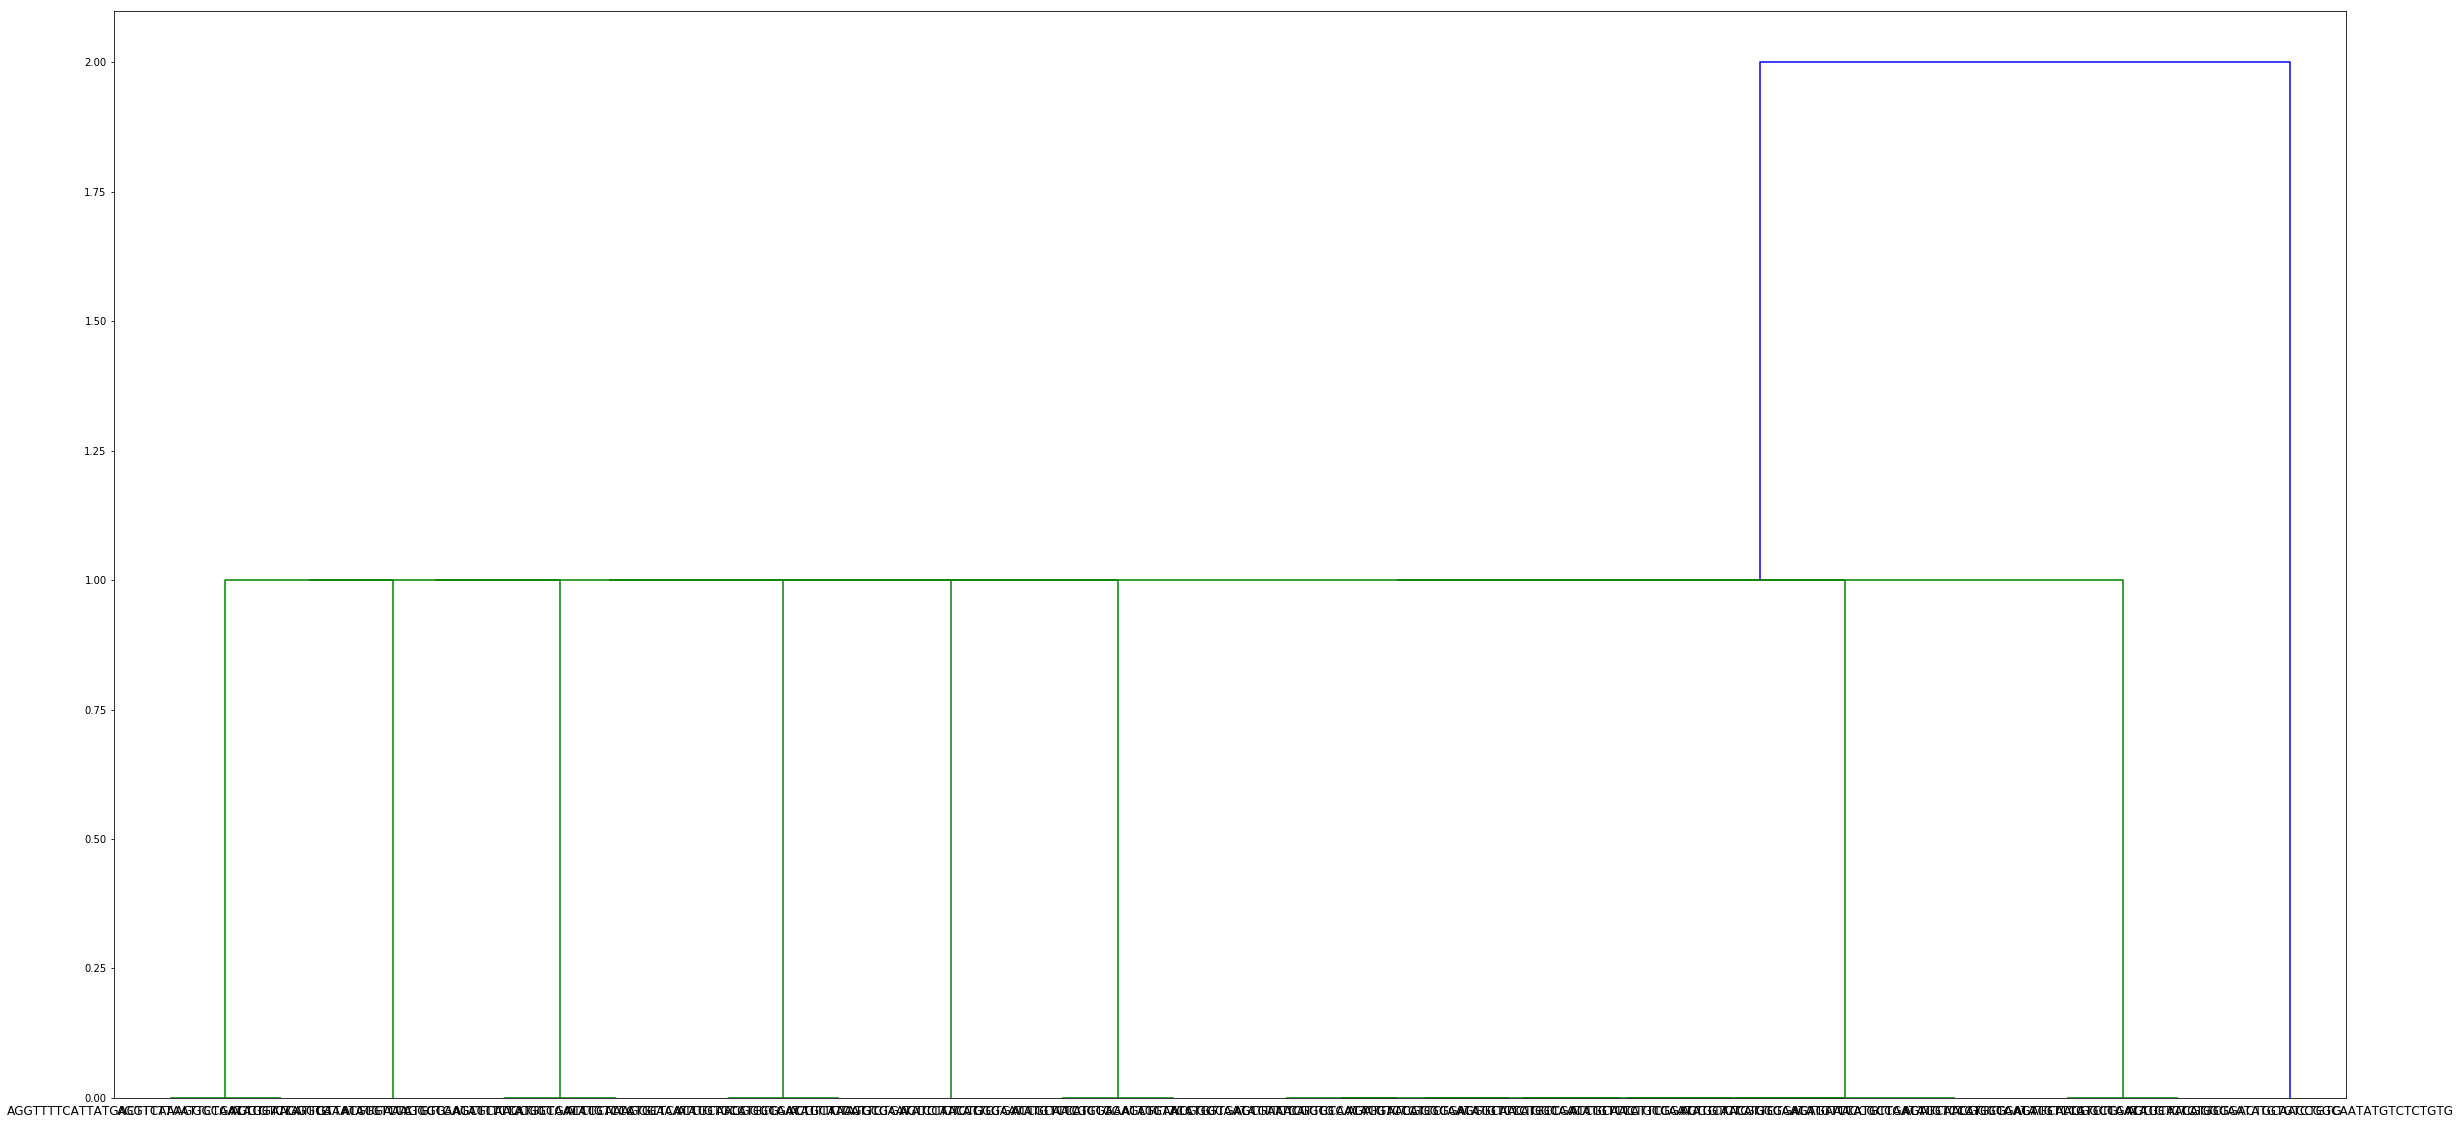

In [333]:
#method is single
linked = linkage(X, method='single', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(40, 20))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

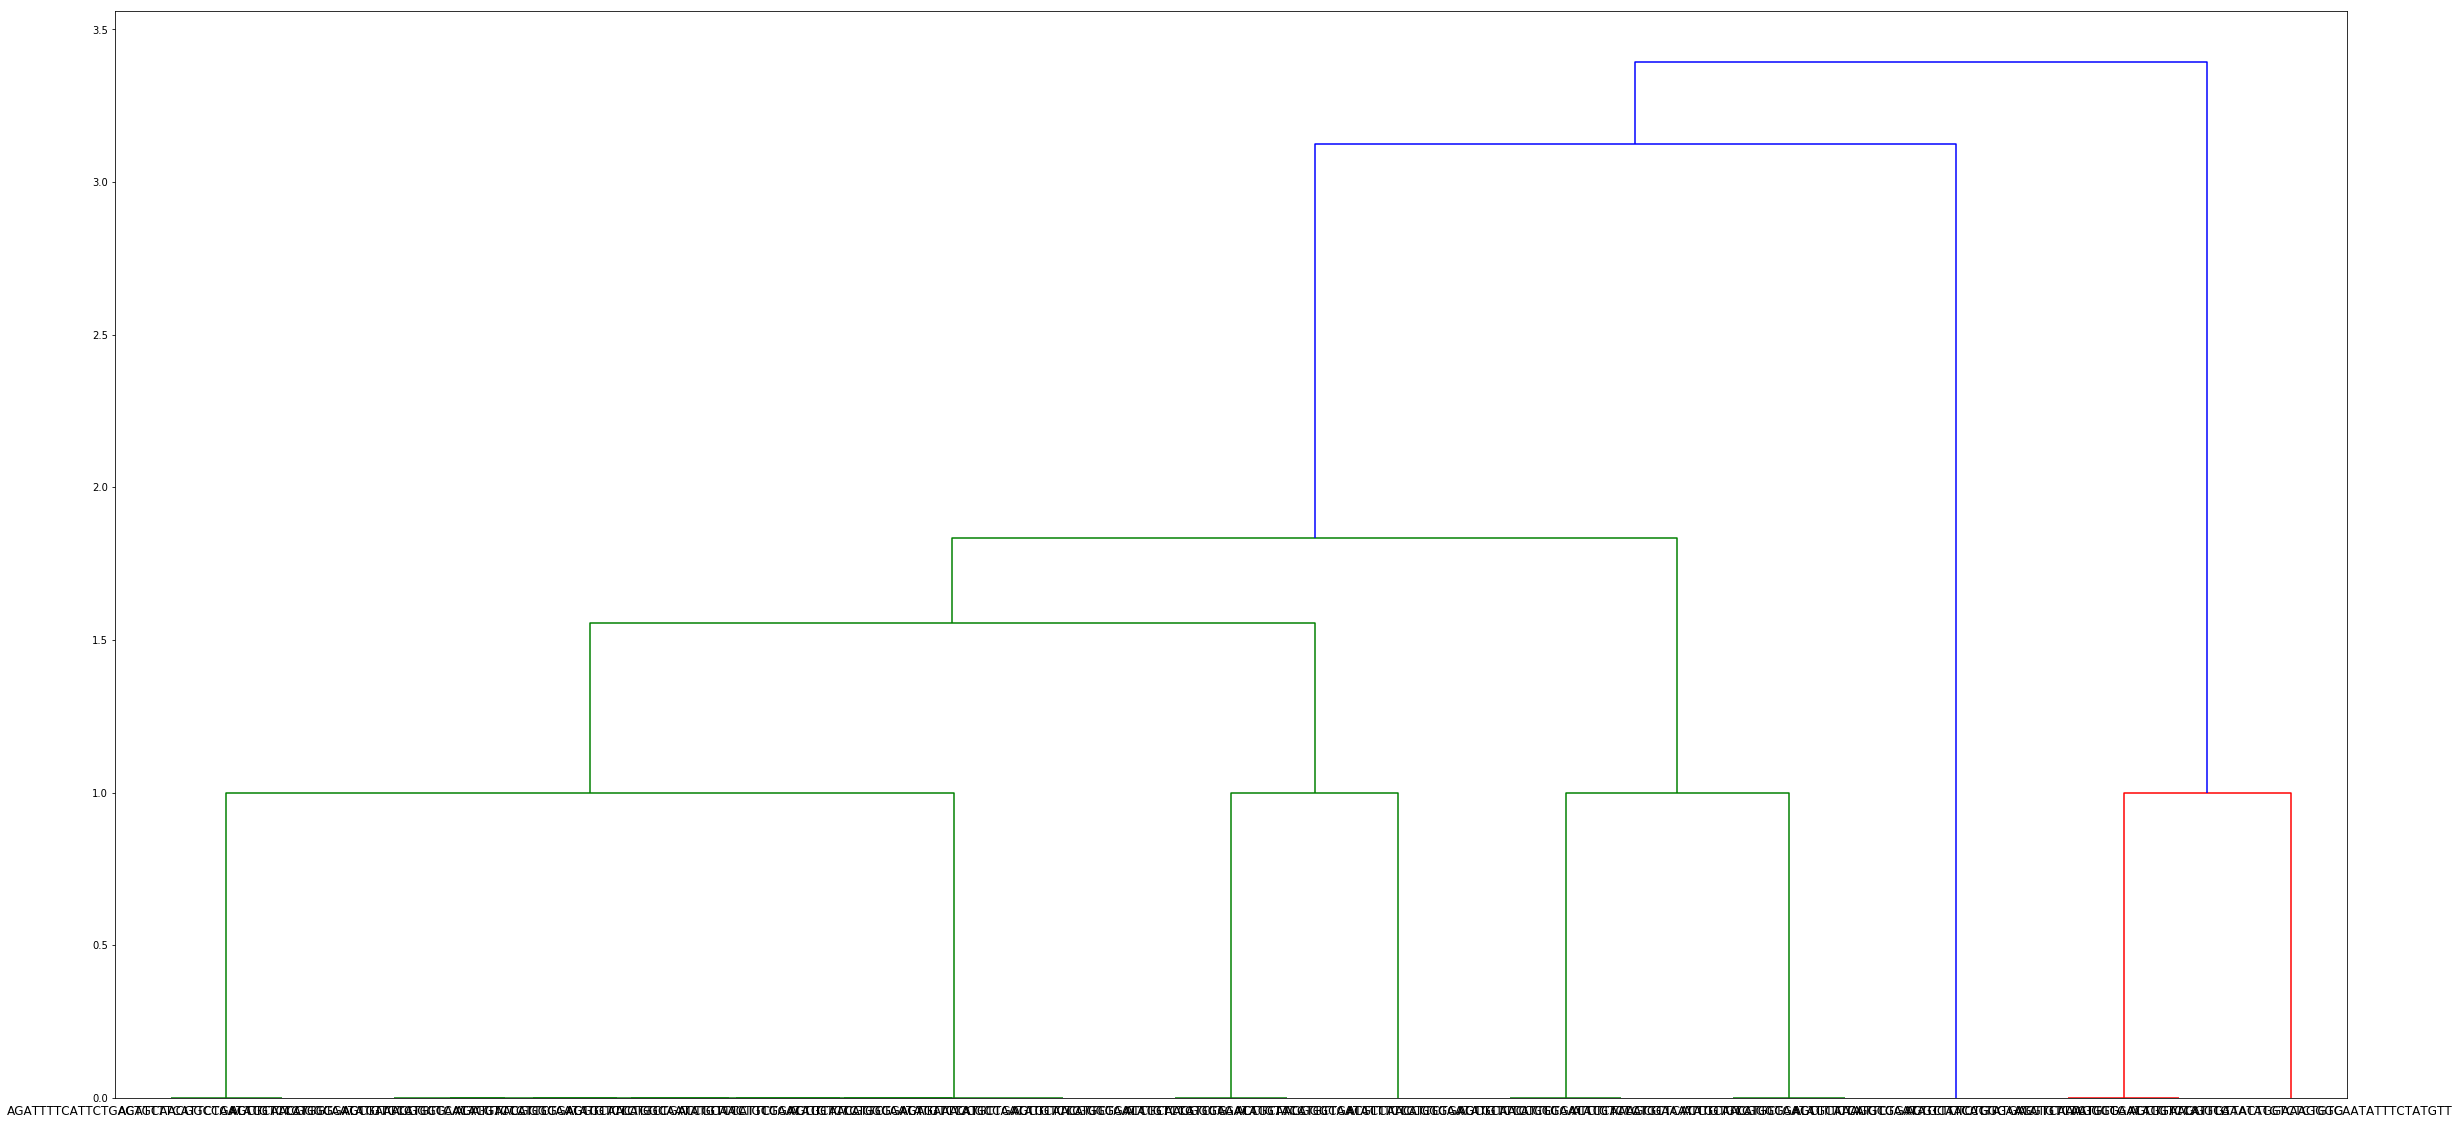

In [334]:
#method is average
linked = linkage(X, method='average', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(40, 20))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

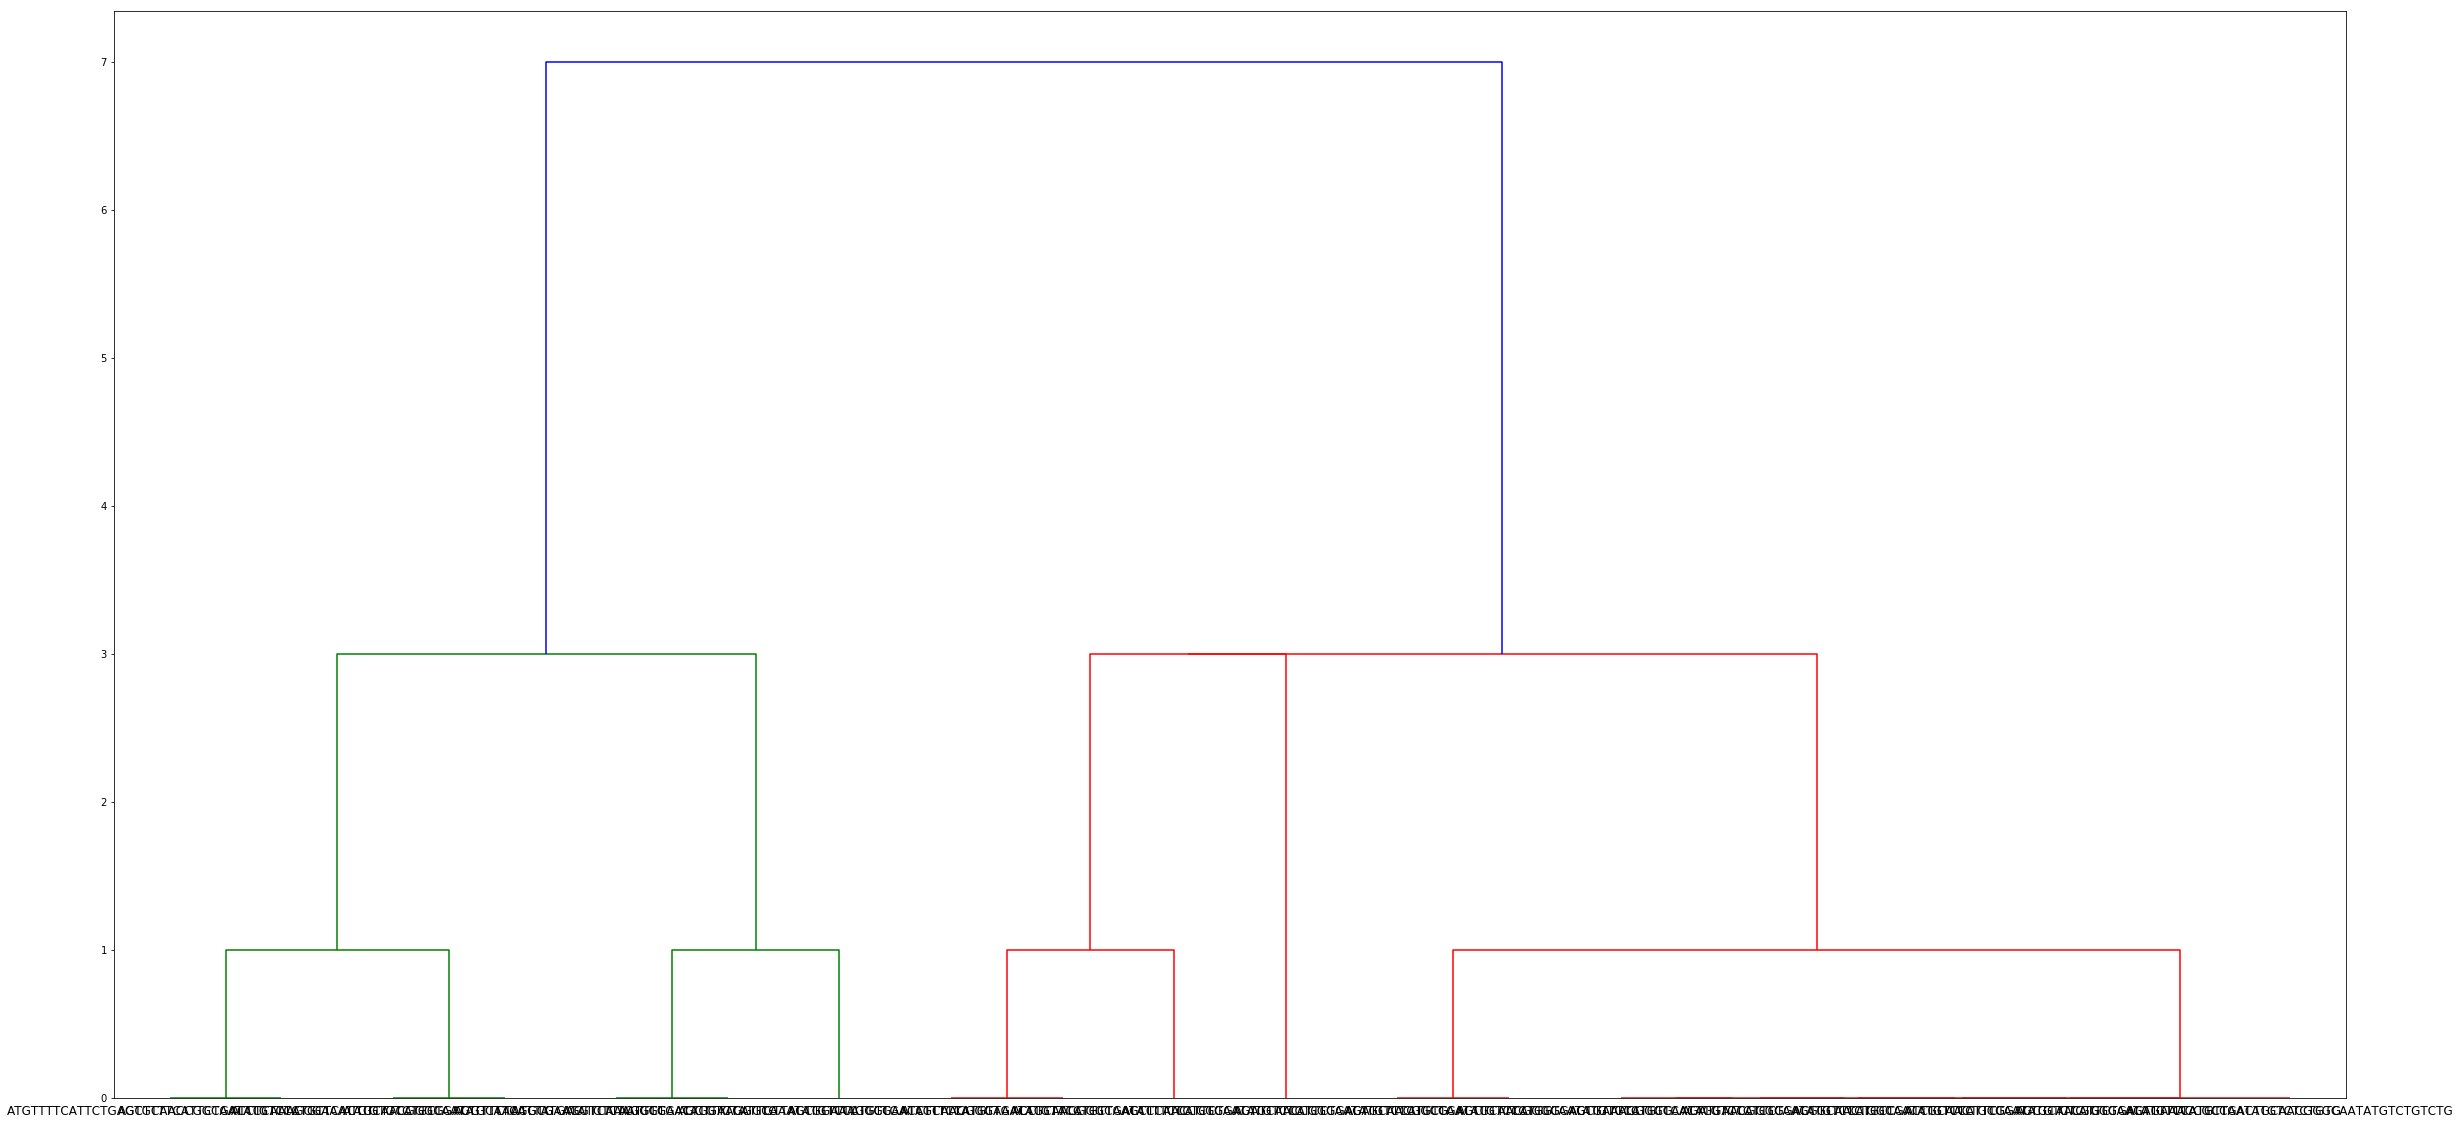

In [335]:
#method is ward
linked = linkage(X, method='complete', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(40, 20))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [336]:
#Sike: Get the latest 4 sequences and generate dendrogram(with 3 methods)
df_mutseq_hamming = df_mutseq_hamming.iloc[-4:]
df_mutseq_hamming_lastest = df_mutseq_hamming[df_mutseq_hamming.columns[2:]]

In [337]:
df_mutseq_hamming_lastest

,hamming_distance,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
Y = df_mutseq_hamming_lastest

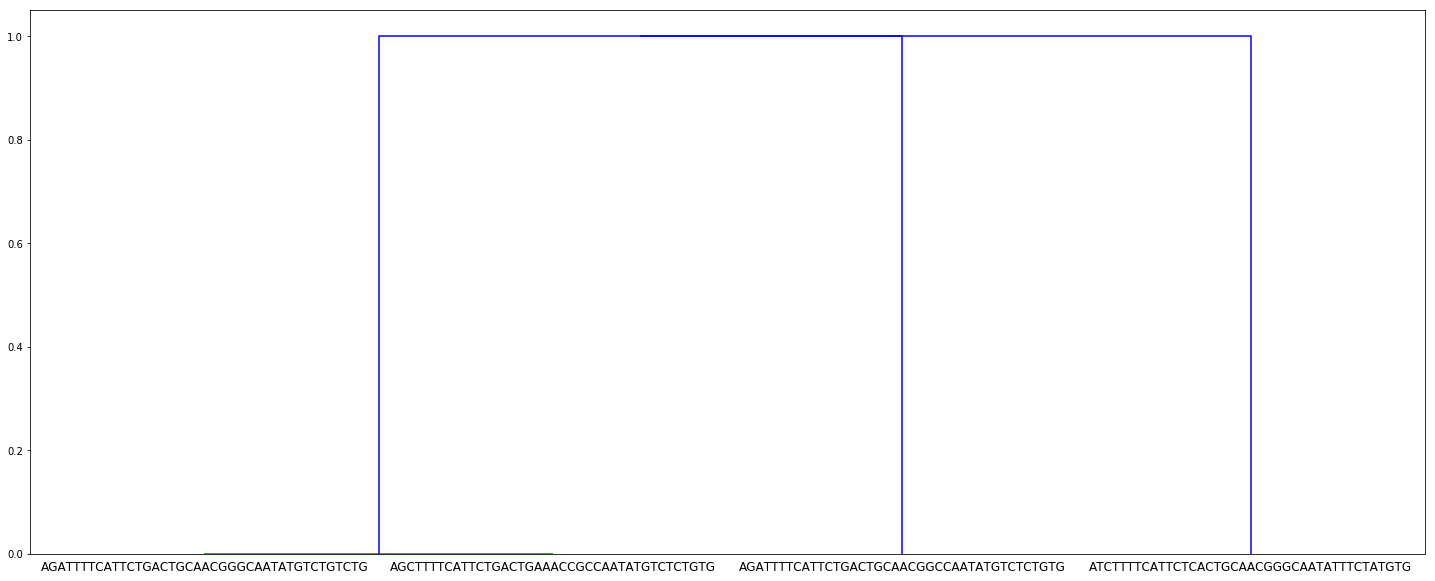

In [345]:
#method is single
linked = linkage(Y, method='single', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(25, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

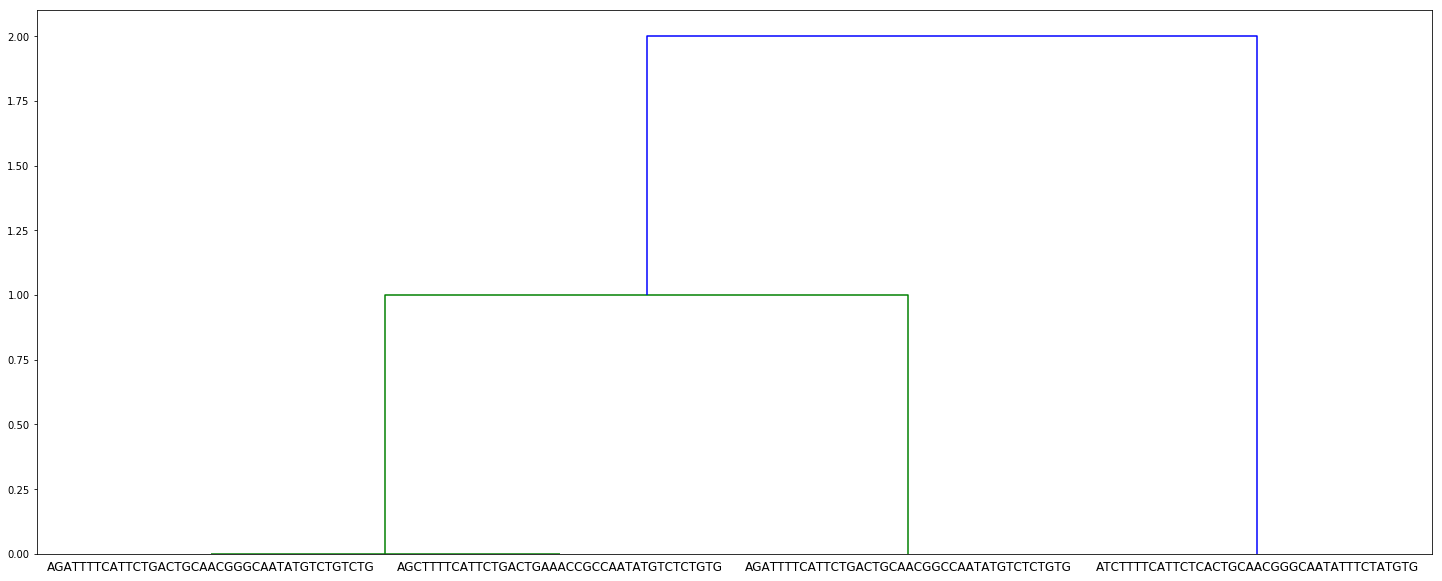

In [346]:
#method is complete
linked = linkage(Y, method='complete', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(25, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

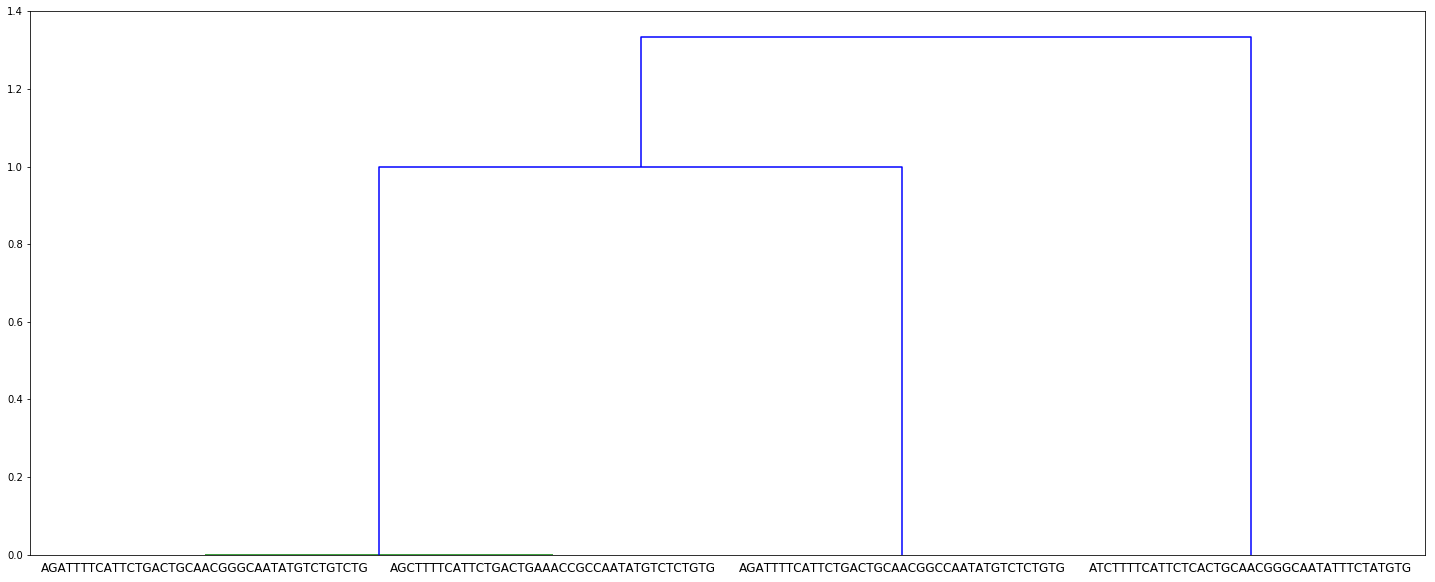

In [347]:
#method is average
linked = linkage(Y, method='average', metric='cityblock')

labelList = list_mut_seq

plt.figure(figsize=(25, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

#### Conclusion(Brief):
1. Since the distance we use is Cityblock(Manhattan), method 'ward' doesn't work. (Ward only works with Euclidean)
2. When there is a few sequences(e.g. 4 sequences here), dendrograms with methods 'complete', 'average', 'single' have the similar shape.
3. When there are more sequences, dendograms look different from each other. With methods 'complete' and 'average', there are more clusters